<a href="https://colab.research.google.com/github/ailunguo/Test/blob/main/Tensorflow_Test/%E7%8C%AB%E7%8B%97_%E5%BE%AE%E8%B0%83%E5%9B%BE%E5%83%8F%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 获取数据集

首先，我们使用 TFDS 获取猫狗数据集。
迁移学习在处理非常小的数据集时最有用。
为了保持数据集较小，我们将使用40%的原始训练数据（25,000张图像）进行训练，10%用于验证，10%用于测试。

In [2]:
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt

In [1]:
import tensorflow_datasets as tfds

In [4]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    'cats_vs_dogs',
    split=['train[:40%]', 'train[40%:50%]', 'train[50%:60%]'],
    as_supervised=True,  # 包含标签
)

print('Number of training samples: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation samples: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test samples: %d' % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


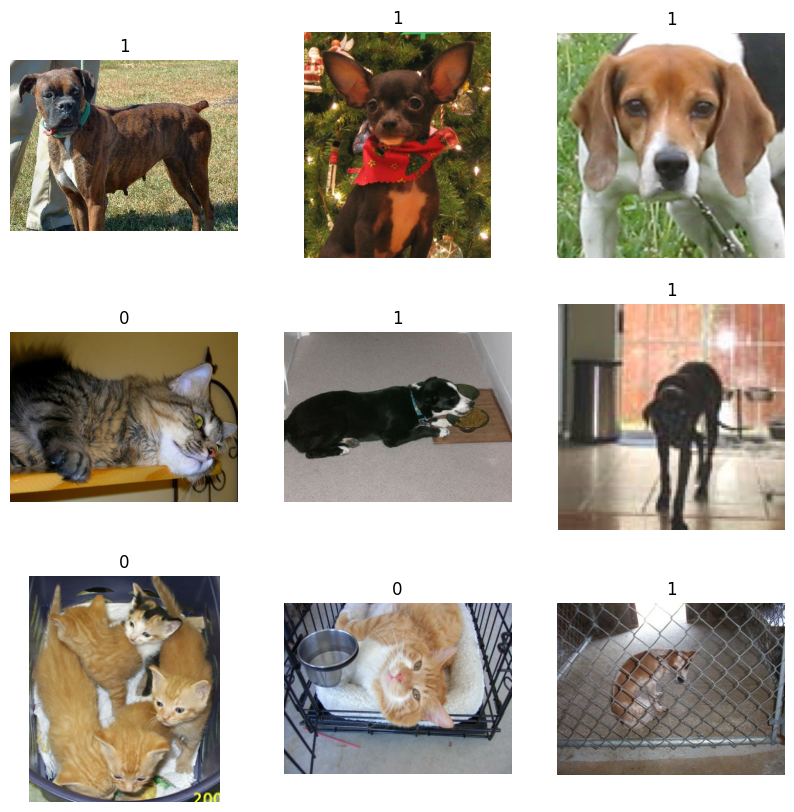

In [7]:
# 这些是训练数据集中的前9张图像,它们的大小都不同。
# 标签1是"狗"，0是"猫"
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

# 数据标准化

标准化为固定图像尺寸。我们选择150x150。

将像素值标准化在-1和1之间。我们将使用Normalization图层作为模型本身的一部分来完成此操作。

一般来说，开发以原始数据作为输入的模型是一种很好的做法，而不是采用已经预处理的数据的模型。

就是把数据预处理的模型也放到模型里面

In [13]:
# 调整图像的大小
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [14]:
# 对数据进行批处理并使用缓存和预取来优化加载速度。
batch_size = 32

# .prefetch() 方法，它的作用是在训练过程中异步加载数据，以减少数据加载的等待时间。buffer_size 参数定义了要预取的元素数目。
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# 使用随机数据增强

当您没有大型图像数据集时，最好的做法是通过对训练图像应用随机但真实的变换（例如随机水平翻转或小型随机旋转）来人为地引入样本多样性。这有助于让模型接触训练数据的不同方面，同时减缓过度拟合。

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip('horizontal'),
      layers.RandomRotation(0.1),
    ]
)

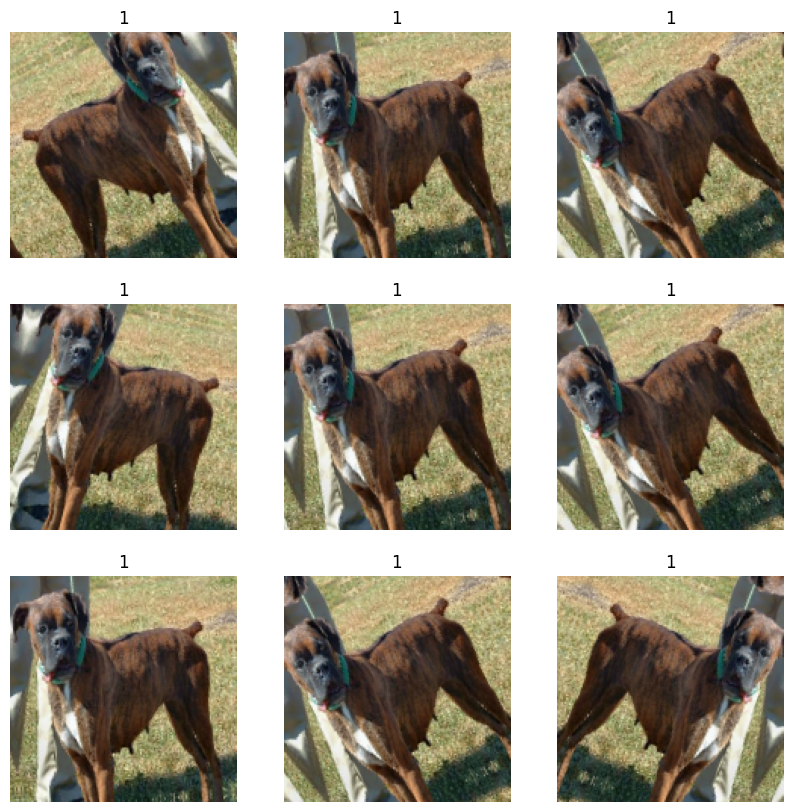

In [16]:
# 看一下第一批的第一张图像经过各种随机变换后的样子
import numpy as np

for images, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype('int32'))
    plt.title(int(labels[0]))
    plt.axis('off')

# 建立一个模型

加一个Rescaling层，将像素标准化到(-1, 1)之间

在classification layer之前加一个Dropout层用来regularization

In [17]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False,
)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale= 1/127.5, offset=-1) # 除127.5之后-1
x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0      

# 训练新加的层

In [18]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - ETA: 0s - loss: 0.1603 - binary_accuracy: 0.9312

KeyboardInterrupt: ignored

# 对整个模型进行一轮微调

In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer = keras.layers.optimizers.Adam(1e-5),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)